In [1]:
import pandas as pd
from nltk.tokenize import word_tokenize
import string

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\redic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from pymorphy2 import MorphAnalyzer

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Загрузка датасета и описание его основных характеристик

In [5]:
news = pd.read_csv('Russia_News.csv', encoding='utf-8')

In [6]:
news.head()

title           topic
0  Microsoft обвиняется в подсуживании в пользу К...  Интернет и СМИ
1  Сайт кандидата в президенты США был взломан на...  Интернет и СМИ
2  ФБР выпустит предупреждение-2000 для правоохра...  Интернет и СМИ
3  Треть российских компьютерных систем не готова...  Интернет и СМИ
4           Интернет скоро похоронит бумажные письма  Интернет и СМИ

В датасете содержаться названия статей и к какой из трех тем ("Интернет и СМИ", "Из жизни", "Путешествия") они принадлежат. Посмотрим количество статей по каждой рубрике.

In [7]:
news['topic'].value_counts()

Интернет и СМИ    44663
Из жизни          27605
Путешествия        6408
Name: topic, dtype: int64

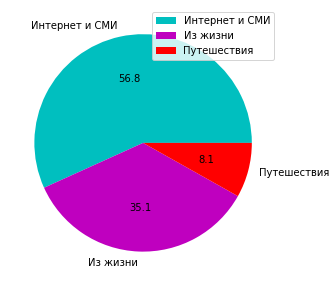

In [8]:
internet = news[news['topic'] == 'Интернет и СМИ'].shape[0]
life = news[news['topic'] == 'Из жизни'].shape[0]
travel = news[news['topic'] == 'Путешествия'].shape[0]
uni_pie = pd.DataFrame({"": [internet, life, travel]},
                       index=["Интернет и СМИ", "Из жизни", "Путешествия"])
uni_pie.plot.pie(y="",
                 colors=["c", "m", "r"],
                 autopct="%.1f",
                 fontsize=10,
                 figsize=(5, 5));

Основные характеристики датасета

In [9]:
from statistics import median
text_of_all_news = []
for t in news['title']:
    text_of_all_news.append(t)
a = 0
for st in text_of_all_news:
    a += int(len(st.split()))
aver_words = a/news.shape[0]
med = []
for t in news['title']:
    med.append(int(len(t.split())))
med = median(med)
print('Количество строк: {}'.format(news.shape[0]))
print('Суммарное количество слов по всем заголовкам: {}'.format(a))
print('Среднее количество слов на один заголовок: {}'.format(aver_words))
print('Медиана количества слов на один заголовок: {}'.format(med))

Количество строк: 78676
Суммарное количество слов по всем заголовкам: 592147
Среднее количество слов на один заголовок: 7.526399410239463
Медиана количества слов на один заголовок: 7.0


# Предобработка текста

In [10]:
list_of_texts = news['title'].to_list()

In [11]:
list_of_texts[:10]

['Microsoft обвиняется в\xa0подсуживании в\xa0пользу Каспарова',
 'Сайт кандидата в\xa0президенты США был взломан на\xa0пять минут',
 'ФБР выпустит предупреждение-2000\xa0для правоохранительных органов',
 'Треть российских компьютерных систем не\xa0готова к\xa02000\xa0году',
 'Интернет скоро похоронит бумажные письма',
 'Центризбирком решил помочь электронным СМИ освещать выборы',
 'Интернет: ты\xa0помнишь, как все начиналось?',
 '"Проблема-2000" может привести к\xa0химической катастрофе',
 'Неизвестный хакер взломал компьютерную сеть в\xa0защиту империи',
 'Морская пехота борется с "червем"']

### Очистим текст от пунктуации, чисел и стоп-слов, приведем все слова к нижнему регистру

In [12]:
import re
nltk.download('stopwords')
nltk.download('punkt')
punct = string.punctuation + "—" + "«" + "»"
from nltk.corpus import stopwords
stopwords_list = stopwords.words("russian")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\redic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\redic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
for i in range(len(list_of_texts)):
    list_of_texts[i] = re.sub(r'[0-9]+', ' ', list_of_texts[i])
    list_of_texts[i] = re.sub(r"\b([а-яА-Я]\.)",' ', list_of_texts[i])
    list_of_texts[i] = re.sub(r"\xa0",' ', list_of_texts[i])
    tokens = word_tokenize(list_of_texts[i])    
    tokens = [token.lower() for token in tokens if token not in punct]
    list_of_texts[i] = [word for word in tokens if word not in stopwords_list]

In [14]:
list_of_texts[:5]

[['microsoft', 'обвиняется', 'подсуживании', 'пользу', 'каспарова'],
 ['сайт', 'кандидата', 'президенты', 'сша', 'взломан', 'пять', 'минут'],
 ['фбр', 'выпустит', 'предупреждение-', 'правоохранительных', 'органов'],
 ['треть', 'российских', 'компьютерных', 'систем', 'готова', 'году'],
 ['интернет', 'скоро', 'похоронит', 'бумажные', 'письма']]

### Лемматизация 

In [15]:
import pymorphy2
analyzer = pymorphy2.MorphAnalyzer()

Избавимся от местоимений-существительный, предлогов, союзов, частиц и междометий и прведем оставшиеся слова к начальной форме

In [16]:
all_lemma = []

for i in range(len(list_of_texts)):
    one_lemma = []
    for word in list_of_texts[i]:
        if analyzer.parse(word)[0].tag.POS in ('NPRO', 'PREP', 'CONJ', 'PRCL', 'INTJ'):
            continue
        if analyzer.parse(word)[0].tag.POS is not None:
            one_lemma.append(analyzer.parse(word)[0].normal_form)
    all_lemma.append(one_lemma)

In [17]:
all_lemma[:10]

[['обвиняться', 'подсуживание', 'польза', 'каспаров'],
 ['сайт', 'кандидат', 'президент', 'сша', 'взломать', 'пять', 'минута'],
 ['фбр', 'выпустить', 'правоохранительный', 'орган'],
 ['треть', 'российский', 'компьютерный', 'система', 'готовый', 'год'],
 ['интернет', 'скоро', 'похоронить', 'бумажный', 'письмо'],
 ['центризбирком',
  'решить',
  'помочь',
  'электронный',
  'сми',
  'освещать',
  'выборы'],
 ['интернет', 'помнить', 'начинаться'],
 ['привести', 'химический', 'катастрофа'],
 ['неизвестный',
  'хакер',
  'взломать',
  'компьютерный',
  'сеть',
  'защита',
  'империя'],
 ['морской', 'пехота', 'бороться', 'червь']]

### Разделим наш датасет на обучающую и тестовую части

In [18]:
y = news['topic']

In [19]:
X = [' '.join(text) for text in all_lemma]
X[:5]

['обвиняться подсуживание польза каспаров',
 'сайт кандидат президент сша взломать пять минута',
 'фбр выпустить правоохранительный орган',
 'треть российский компьютерный система готовый год',
 'интернет скоро похоронить бумажный письмо']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Мешок n-грамм и мешок слов

In [23]:
from nltk import ngrams

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score
from sklearn.metrics import * 

In [86]:
dic_ngrams = {'n-gramms (1,2)': (1,2), 'n-gramms (1,3)': (1,3), 'n-gramms (1,4) ': (1,4), 'n-gramms (1,5)': (1,5), 'n-gramms (1,6)': (1,6), 'bag of words': (1,1)}
vectorizers = {'vectorizer': [], 'precision': [], 'recall': [],
              'accuracy': [], 'f_1': []}

In [87]:
for name, rng in dic_ngrams.items():
    vectorizer = CountVectorizer(ngram_range=rng)
    vectorized_x_train = vectorizer.fit_transform(X_train)
    clf = MultinomialNB()
    clf.fit(vectorized_x_train, y_train)
    vectorized_x_test = vectorizer.transform(X_test)
    pred = clf.predict(vectorized_x_test)
    vectorizers['vectorizer'].append(name)
    vectorizers['precision'].append(precision_score(y_test, pred, average='macro'))
    vectorizers['recall'].append(recall_score(y_test, pred, average='macro'))
    vectorizers['accuracy'].append(accuracy_score(y_test, pred))
    vectorizers['f_1'].append(f1_score(y_test, pred, average='macro'))

In [88]:
df = pd.DataFrame.from_dict(vectorizers)
df

vectorizer  precision    recall  accuracy       f_1
0   n-gramms (1,2)   0.892957  0.797901  0.879911  0.833219
1   n-gramms (1,3)   0.892780  0.782013  0.875481  0.821056
2  n-gramms (1,4)    0.892198  0.773682  0.872747  0.814260
3   n-gramms (1,5)   0.892474  0.769994  0.871668  0.811352
4   n-gramms (1,6)   0.892020  0.767287  0.871091  0.808967
5     bag of words   0.869392  0.844369  0.886112  0.855720

# Символьные n-граммы

In [89]:
dic_char = {'n-char (2,8)': (2,8), 'n-char (2,9)': (2,9), 'n-char (2,10)': (2,10), 'n-char (3,8)': (3,8), 'n-char (3,9)': (3,9), 'n-char (3,10)': (3,10),
           'n-char (4,8)': (4,8), 'n-char (4,9)': (4,9), 'n-char (4,10)': (4,10)}

In [90]:
for name, rng in dic_char.items():
    char_vectorizer = CountVectorizer(analyzer='char', ngram_range=rng)
    char_vectorized_x_train = char_vectorizer.fit_transform(X_train)
    clf = MultinomialNB()
    clf.fit(char_vectorized_x_train, y_train)
    char_vectorized_x_test = char_vectorizer.transform(X_test)
    pred = clf.predict(char_vectorized_x_test)
    vectorizers['vectorizer'].append(name)
    vectorizers['precision'].append(precision_score(y_test, pred, average='macro'))
    vectorizers['recall'].append(recall_score(y_test, pred, average='macro'))
    vectorizers['accuracy'].append(accuracy_score(y_test, pred))
    vectorizers['f_1'].append(f1_score(y_test, pred, average='macro'))

In [91]:
tb = pd.DataFrame.from_dict(vectorizers)
tb

vectorizer  precision    recall  accuracy       f_1
0    n-gramms (1,2)   0.892957  0.797901  0.879911  0.833219
1    n-gramms (1,3)   0.892780  0.782013  0.875481  0.821056
2   n-gramms (1,4)    0.892198  0.773682  0.872747  0.814260
3    n-gramms (1,5)   0.892474  0.769994  0.871668  0.811352
4    n-gramms (1,6)   0.892020  0.767287  0.871091  0.808967
5      bag of words   0.869392  0.844369  0.886112  0.855720
6      n-char (2,8)   0.866163  0.819089  0.873209  0.838977
7      n-char (2,9)   0.869637  0.806701  0.871553  0.832170
8     n-char (2,10)   0.872486  0.797755  0.870397  0.827045
9      n-char (3,8)   0.863365  0.826385  0.874365  0.842496
10     n-char (3,9)   0.866277  0.816941  0.873016  0.837856
11    n-char (3,10)   0.869061  0.808689  0.872131  0.833531
12     n-char (4,8)   0.859262  0.830552  0.874827  0.843430
13     n-char (4,9)   0.863322  0.821256  0.873825  0.839501
14    n-char (4,10)   0.864270  0.816462  0.872593  0.836949

# TF-IDF векторизация

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [93]:
rng = [(1, 3), (1,4), (1,5)]
max_df = [0.75, 0.85, 0.95]
min_df = [3, 4, 5]

In [94]:
for r in rng:
    for max_d in max_df:
        for min_d in min_df:
            name = 'tf-idf'
            tfidf_vectorizer = TfidfVectorizer(ngram_range=r, max_df = max_d, min_df = min_d)
            tfidf_vectorized_x_train = tfidf_vectorizer.fit_transform(X_train)
            clf = MultinomialNB()
            clf.fit(tfidf_vectorized_x_train, y_train)
            tfidf_vectorized_x_test = tfidf_vectorizer.transform(X_test)
            pred = clf.predict(tfidf_vectorized_x_test)
            vectorizers['vectorizer'].append(f"{name}, {r}, {max_d}, {min_d}")
            vectorizers['precision'].append(precision_score(y_test, pred, average='macro'))
            vectorizers['recall'].append(recall_score(y_test, pred, average='macro'))
            vectorizers['accuracy'].append(accuracy_score(y_test, pred))
            vectorizers['f_1'].append(f1_score(y_test, pred, average='macro'))

In [95]:
vctrz = pd.DataFrame.from_dict(vectorizers)
vctrz

vectorizer  precision    recall  accuracy       f_1
0            n-gramms (1,2)   0.892957  0.797901  0.879911  0.833219
1            n-gramms (1,3)   0.892780  0.782013  0.875481  0.821056
2           n-gramms (1,4)    0.892198  0.773682  0.872747  0.814260
3            n-gramms (1,5)   0.892474  0.769994  0.871668  0.811352
4            n-gramms (1,6)   0.892020  0.767287  0.871091  0.808967
5              bag of words   0.869392  0.844369  0.886112  0.855720
6              n-char (2,8)   0.866163  0.819089  0.873209  0.838977
7              n-char (2,9)   0.869637  0.806701  0.871553  0.832170
8             n-char (2,10)   0.872486  0.797755  0.870397  0.827045
9              n-char (3,8)   0.863365  0.826385  0.874365  0.842496
10             n-char (3,9)   0.866277  0.816941  0.873016  0.837856
11            n-char (3,10)   0.869061  0.808689  0.872131  0.833531
12             n-char (4,8)   0.859262  0.830552  0.874827  0.843430
13             n-char (4,9)   0.863322  0.821256  0.873825  0.839501
14            n-char (4,10)   0.864270  0.816462  0.872593  0.836949
15  tf-idf, (1, 3), 0.75, 3   0.885855  0.757109  0.865737  0.797683
16  tf-idf, (1, 3), 0.75, 4   0.884809  0.771036  0.867778  0.809506
17  tf-idf, (1, 3), 0.75, 5   0.882150  0.777983  0.868780  0.814731
18  tf-idf, (1, 3), 0.85, 3   0.885855  0.757109  0.865737  0.797683
19  tf-idf, (1, 3), 0.85, 4   0.884809  0.771036  0.867778  0.809506
20  tf-idf, (1, 3), 0.85, 5   0.882150  0.777983  0.868780  0.814731
21  tf-idf, (1, 3), 0.95, 3   0.885855  0.757109  0.865737  0.797683
22  tf-idf, (1, 3), 0.95, 4   0.884809  0.771036  0.867778  0.809506
23  tf-idf, (1, 3), 0.95, 5   0.882150  0.777983  0.868780  0.814731
24  tf-idf, (1, 4), 0.75, 3   0.885651  0.756378  0.865506  0.796997
25  tf-idf, (1, 4), 0.75, 4   0.884666  0.770153  0.867663  0.808714
26  tf-idf, (1, 4), 0.75, 5   0.882131  0.777932  0.868741  0.814696
27  tf-idf, (1, 4), 0.85, 3   0.885651  0.756378  0.865506  0.796997
28  tf-idf, (1, 4), 0.85, 4   0.884666  0.770153  0.867663  0.808714
29  tf-idf, (1, 4), 0.85, 5   0.882131  0.777932  0.868741  0.814696
30  tf-idf, (1, 4), 0.95, 3   0.885651  0.756378  0.865506  0.796997
31  tf-idf, (1, 4), 0.95, 4   0.884666  0.770153  0.867663  0.808714
32  tf-idf, (1, 4), 0.95, 5   0.882131  0.777932  0.868741  0.814696
33  tf-idf, (1, 5), 0.75, 3   0.885651  0.756378  0.865506  0.796997
34  tf-idf, (1, 5), 0.75, 4   0.884666  0.770153  0.867663  0.808714
35  tf-idf, (1, 5), 0.75, 5   0.882359  0.777932  0.868741  0.814756
36  tf-idf, (1, 5), 0.85, 3   0.885651  0.756378  0.865506  0.796997
37  tf-idf, (1, 5), 0.85, 4   0.884666  0.770153  0.867663  0.808714
38  tf-idf, (1, 5), 0.85, 5   0.882359  0.777932  0.868741  0.814756
39  tf-idf, (1, 5), 0.95, 3   0.885651  0.756378  0.865506  0.796997
40  tf-idf, (1, 5), 0.95, 4   0.884666  0.770153  0.867663  0.808714
41  tf-idf, (1, 5), 0.95, 5   0.882359  0.777932  0.868741  0.814756

# Какой векторайзер дает наилучший результат?

### Precision (точность)

Точность системы в пределах класса – это доля документов действительно принадлежащих данному классу относительно всех документов которые система отнесла к этому классу. 

In [96]:
vctrz.sort_values(by = 'precision', ascending=False)[:5]

vectorizer  precision    recall  accuracy       f_1
0   n-gramms (1,2)   0.892957  0.797901  0.879911  0.833219
1   n-gramms (1,3)   0.892780  0.782013  0.875481  0.821056
3   n-gramms (1,5)   0.892474  0.769994  0.871668  0.811352
2  n-gramms (1,4)    0.892198  0.773682  0.872747  0.814260
4   n-gramms (1,6)   0.892020  0.767287  0.871091  0.808967

Самым точным оказался n-gramms (1,2) векторайзер

### Recall (полнота)

Полнота системы – это доля найденных классфикатором документов принадлежащих классу относительно всех документов этого класса в тестовой выборке.

In [97]:
vctrz.sort_values(by = 'recall', ascending=False)[:5]

vectorizer  precision    recall  accuracy       f_1
5   bag of words   0.869392  0.844369  0.886112  0.855720
12  n-char (4,8)   0.859262  0.830552  0.874827  0.843430
9   n-char (3,8)   0.863365  0.826385  0.874365  0.842496
13  n-char (4,9)   0.863322  0.821256  0.873825  0.839501
6   n-char (2,8)   0.866163  0.819089  0.873209  0.838977

Значение по полноте выше у  векторайзера 'Мешок слов'

### Accuracy (доля документов по которым классификатор принял правильное решение)

In [98]:
vctrz.sort_values(by = 'accuracy', ascending=False)[:5]

vectorizer  precision    recall  accuracy       f_1
5     bag of words   0.869392  0.844369  0.886112  0.855720
0   n-gramms (1,2)   0.892957  0.797901  0.879911  0.833219
1   n-gramms (1,3)   0.892780  0.782013  0.875481  0.821056
12    n-char (4,8)   0.859262  0.830552  0.874827  0.843430
9     n-char (3,8)   0.863365  0.826385  0.874365  0.842496

Более высокая точность у Мешка слов

### F мера 

F-мера представляет собой гармоническое среднее между точностью и полнотой. Она стремится к нулю, если точность или полнота стремится к нулю.



In [99]:
vctrz.sort_values(by = 'f_1', ascending=False)[:5]

vectorizer  precision    recall  accuracy       f_1
5   bag of words   0.869392  0.844369  0.886112  0.855720
12  n-char (4,8)   0.859262  0.830552  0.874827  0.843430
9   n-char (3,8)   0.863365  0.826385  0.874365  0.842496
13  n-char (4,9)   0.863322  0.821256  0.873825  0.839501
6   n-char (2,8)   0.866163  0.819089  0.873209  0.838977

F-мера выше у векторайзера "Мешок слов"

#### В большинстве случаев лучший результат достигается при использовании векторайзера "Мешок слов"